In [24]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pseudo_code_from_Max import generate_system_mueller_matrix, generate_measurement

# Load the CSV file
csv_file_path = "20230914_processed_table.csv"
data = pd.read_csv(csv_file_path)

# Ensure relevant columns are properly formatted as strings
data["diff"] = data["diff"].astype(str)
data["sum"] = data["sum"].astype(str)
data["diff_std"] = data["diff_std"].astype(str)
data["sum_std"] = data["sum_std"].astype(str)

# Extract unique values
HWP_angs = np.sort(data["RET-POS1"].unique())
IMR_angs = np.sort(data["D_IMRANG"].unique())

# Prepare output directory
output_dir = os.path.dirname(csv_file_path)

# User-defined wavelength to analyze
open_wavelengths = [610, 670, 720, 760]
wavelength = "670"
json_file_path = f"instrument_configurations_{wavelength}.json"

# Load previous fit values
previous_fit = np.load(f"scipy_minimize_20230914_{wavelength}nm_restrictive_HWP_and_IMR.npy")

# Extract parameters from previous fit
theta_pol = previous_fit[0]
delta_HWP = previous_fit[1]
offset_HWP = previous_fit[2]
delta_derot = previous_fit[3]
offset_derot = previous_fit[4]
delta_opts = previous_fit[5]
epsilon_opts = previous_fit[6]
rot_opts = previous_fit[7]
delta_FLC = previous_fit[8]
rot_FLC = previous_fit[9]
em_gain = previous_fit[10]

# Data storage
double_diffs = []
double_sums = []
double_diff_stds = []
double_sum_stds = []
hwp_angles = []
imr_angles = []
configurations = [] 

# Loop through each HWP and IMR combination
for HWP_ang in HWP_angs:
    for IMR_ang in IMR_angs:
        mask_A = (data["OBS-MOD"] == "IPOL_MBI") & (data["RET-POS1"] == HWP_ang) & (data["D_IMRANG"] == IMR_ang) & (data["U_FLC"] == "A")
        mask_B = (data["OBS-MOD"] == "IPOL_MBI") & (data["RET-POS1"] == HWP_ang) & (data["D_IMRANG"] == IMR_ang) & (data["U_FLC"] == "B")

        # Extract values for both FLC states
        diff_A_list = data[mask_A]["diff"].values
        diff_B_list = data[mask_B]["diff"].values
        sum_A_list = data[mask_A]["sum"].values
        sum_B_list = data[mask_B]["sum"].values
        diff_std_A_list = data[mask_A]["diff_std"].values
        diff_std_B_list = data[mask_B]["diff_std"].values
        sum_std_A_list = data[mask_A]["sum_std"].values
        sum_std_B_list = data[mask_B]["sum_std"].values

        if len(diff_A_list) > 0 and len(diff_B_list) > 0:
            try:
                open_wavelength_idx = open_wavelengths.index(int(wavelength))  # Find correct index

                # Convert values from string to float
                diff_A = float(diff_A_list[0].strip("[]").split()[open_wavelength_idx])
                diff_B = float(diff_B_list[0].strip("[]").split()[open_wavelength_idx])
                sum_A = float(sum_A_list[0].strip("[]").split()[open_wavelength_idx])
                sum_B = float(sum_B_list[0].strip("[]").split()[open_wavelength_idx])
                diff_std_A = float(diff_std_A_list[0].strip("[]").split()[open_wavelength_idx])
                diff_std_B = float(diff_std_B_list[0].strip("[]").split()[open_wavelength_idx])
                sum_std_A = float(sum_std_A_list[0].strip("[]").split()[open_wavelength_idx])
                sum_std_B = float(sum_std_B_list[0].strip("[]").split()[open_wavelength_idx])

                # Compute normalized double differences and sums
                unnormalized_double_diff = diff_A - diff_B
                unnormalized_double_sum = diff_A + diff_B
                total_sum = sum_A + sum_B

                normalized_double_diff = unnormalized_double_diff / total_sum
                normalized_double_sum = unnormalized_double_sum / total_sum

                unnormalized_double_diff_std = np.sqrt(diff_std_A ** 2 + diff_std_B ** 2)
                unnormalized_double_sum_std = np.sqrt(diff_std_A ** 2 + diff_std_B ** 2)
                total_sum_std = np.sqrt(sum_std_A ** 2 + sum_std_B ** 2)

                double_diff_std = np.sqrt((unnormalized_double_diff_std / unnormalized_double_diff) ** 2 + 
                                          (total_sum_std / total_sum) ** 2) * normalized_double_diff
                double_sum_std = np.sqrt((unnormalized_double_sum_std / unnormalized_double_sum) ** 2 + 
                                         (total_sum_std / total_sum) ** 2) * normalized_double_sum

                # Append results
                double_diffs.append(normalized_double_diff)
                double_sums.append(normalized_double_sum)
                double_diff_stds.append(double_diff_std)
                double_sum_stds.append(double_sum_std)
                hwp_angles.append(HWP_ang)
                imr_angles.append(IMR_ang)

                # Create system configuration dictionary
                system_dict = {
                    "components": {
                        "parang_rot": {
                            "type": "Rotator",
                            "properties": {"pa": 0},
                            "tag": "on-sky",
                        },
                        "m3": {
                            "type": "DiattenuatorRetarder",
                            "properties": {"phi": 2 * np.pi * 0, "epsilon": 0.03},
                            "tag": "on-sky",
                        },
                        "alt_rot": {
                            "type": "Rotator",
                            "properties": {"pa": 0},
                            "tag": "on-sky",
                        },
                        "lp": {
                            "type": "LinearPolarizer",
                            "properties": {"theta": theta_pol},
                            "tag": "internal",
                        },
                        "hwp": {
                            "type": "Retarder",
                            "properties": {"phi": 2 * np.pi * delta_HWP, "delta_theta": offset_HWP, "theta": HWP_ang},
                            "tag": "internal",
                        },
                        "image_rotator": {
                            "type": "Retarder",
                            "properties": {"phi": 2 * np.pi * delta_derot, "delta_theta": offset_derot, "theta": IMR_ang},
                            "tag": "internal",
                        },
                        "optics": {
                            "type": "DiattenuatorRetarder",
                            "properties": {"phi": 2 * np.pi * rot_opts, "epsilon": epsilon_opts},
                            "tag": "on-sky",
                        },
                        "flc": {
                            "type": "Retarder",
                            "properties": {"phi": 2 * np.pi * delta_FLC, "theta": rot_FLC},
                            "tag": "internal",
                        },
                        "dichroic": {
                            "type": "Retarder",
                            "properties": {"phi": 2 * np.pi * 0, "theta": 0},
                            "tag": "internal",
                        },
                        "wollaston": {
                            "type": "WollastonPrism",
                            "properties": {"beam": "o", "transmission_ratio": em_gain},
                            "tag": "internal",
                        },
                    },
                    "order": [
                        "parang_rot", "m3", "alt_rot", "lp", "hwp",
                        "image_rotator", "optics", "flc", "dichroic", "wollaston"
                    ],
                }
                configurations.append(system_dict)

            except Exception as e:
                print(f"Error processing row for HWP {HWP_ang}, IMR {IMR_ang}: {e}")
                continue

# Convert lists to numpy arrays
double_diffs = np.array(double_diffs)
double_sums = np.array(double_sums)
double_diff_stds = np.array(double_diff_stds)
double_sum_stds = np.array(double_sum_stds)

# Perform optimization using scipy.minimize
starting_guess = np.array([0, 0])  # dichroic_phi, dichroic_theta
bounds = [(0, 1), (-180, 180)]


# Define the objective function
def objective_function(params):
    """
    Objective function to minimize: chi-squared between model and observed data.
    """

    chi_squared = 0

    # Update dichroic parameters
    dichroic_phi, dichroic_theta = params

    for idx, config in enumerate(configurations):
        # Copy base configuration for modifications
        updated_system_dict = config.copy()
        updated_system_dict["components"]["dichroic"]["properties"]["phi"] = dichroic_phi
        updated_system_dict["components"]["dichroic"]["properties"]["theta"] = dichroic_theta

        # Generate Mueller matrices for different flux cases
        updated_system_dict["components"]["wollaston"]["properties"]["beam"] = "o"
        updated_system_dict["components"]["flc"]["properties"]["phi"] = 0  # FLC state A
        system_mm_FL1 = generate_system_mueller_matrix(updated_system_dict)

        updated_system_dict["components"]["wollaston"]["properties"]["beam"] = "e"
        system_mm_FR1 = generate_system_mueller_matrix(updated_system_dict)

        updated_system_dict["components"]["flc"]["properties"]["phi"] = np.pi / 4  # FLC state B
        updated_system_dict["components"]["wollaston"]["properties"]["beam"] = "o"
        system_mm_FL2 = generate_system_mueller_matrix(updated_system_dict)

        updated_system_dict["components"]["wollaston"]["properties"]["beam"] = "e"
        system_mm_FR2 = generate_system_mueller_matrix(updated_system_dict)

        # Print all system Mueller matrices at the end
        # print("\n--- Generated System Mueller Matrices ---\n")
        # print("System Mueller Matrix for FL1 (FLC = A, Beam = o):\n", system_mm_FL1.evaluate(), "\n")
        # print("System Mueller Matrix for FR1 (FLC = A, Beam = e):\n", system_mm_FR1.evaluate(), "\n")
        # print("System Mueller Matrix for FL2 (FLC = B, Beam = o):\n", system_mm_FL2.evaluate(), "\n")
        # print("System Mueller Matrix for FR2 (FLC = B, Beam = e):\n", system_mm_FR2.evaluate(), "\n")

        # Generate simulated Stokes measurements for each configuration
        S_in = [1, 1, 0, 0]  # 100% injected Stokes Q
        FL1 = generate_measurement(system_mm_FL1, S_in)[0]
        FR1 = generate_measurement(system_mm_FR1, S_in)[0]
        FL2 = generate_measurement(system_mm_FL2, S_in)[0]
        FR2 = generate_measurement(system_mm_FR2, S_in)[0]

        # Compute double difference (D) and double sum (S) using equations
        model_double_diff = ((FL1 - FR1) - (FL2 - FR2)) / ((FL1 + FR1) + (FL2 + FR2))
        model_double_sum = ((FL1 - FR1) + (FL2 - FR2)) / ((FL1 + FR1) + (FL2 + FR2))

        # Extract observed values
        observed_double_diff = double_diffs[idx]
        observed_double_sum = double_sums[idx]
        observed_double_diff_std = double_diff_stds[idx]
        observed_double_sum_std = double_sum_stds[idx]

        # Compute chi-squared contribution
        chi_squared += ((model_double_diff - observed_double_diff) / observed_double_diff_std) ** 2
        chi_squared += ((model_double_sum - observed_double_sum) / observed_double_sum_std) ** 2

    return chi_squared

result = minimize(objective_function, starting_guess, bounds=bounds, method="Nelder-Mead")
print(result)


KeyboardInterrupt: 

Extracted Unique HWP Angles: [  0.    11.25  22.5   33.75  45.    56.25  67.5   78.75  90.   101.25
 112.5  123.75 135.   146.25 157.5  168.75]
Extracted Unique IMR Angles: [ 45.   57.5  70.   82.5  95.  107.5 120.  132.5]
Valid HWP and IMR Pairs:  {(56.25, 45.0), (123.75, 70.0), (22.5, 132.5), (101.25, 107.5), (22.5, 107.5), (101.25, 70.0), (22.5, 70.0), (56.25, 120.0), (168.75, 70.0), (22.5, 45.0), (56.25, 95.0), (146.25, 70.0), (33.75, 82.5), (22.5, 120.0), (33.75, 57.5), (0.0, 57.5), (67.5, 82.5), (11.25, 82.5), (78.75, 107.5), (22.5, 95.0), (67.5, 57.5), (11.25, 57.5), (78.75, 82.5), (45.0, 82.5), (112.5, 107.5), (33.75, 132.5), (0.0, 132.5), (78.75, 57.5), (45.0, 57.5), (33.75, 107.5), (0.0, 107.5), (67.5, 132.5), (11.25, 132.5), (33.75, 70.0), (0.0, 82.5), (67.5, 107.5), (157.5, 107.5), (11.25, 107.5), (33.75, 45.0), (0.0, 45.0), (45.0, 132.5), (78.75, 132.5), (67.5, 70.0), (11.25, 70.0), (78.75, 95.0), (45.0, 107.5), (135.0, 107.5), (67.5, 45.0), (11.25, 45.0), (78.75, 70.0), (

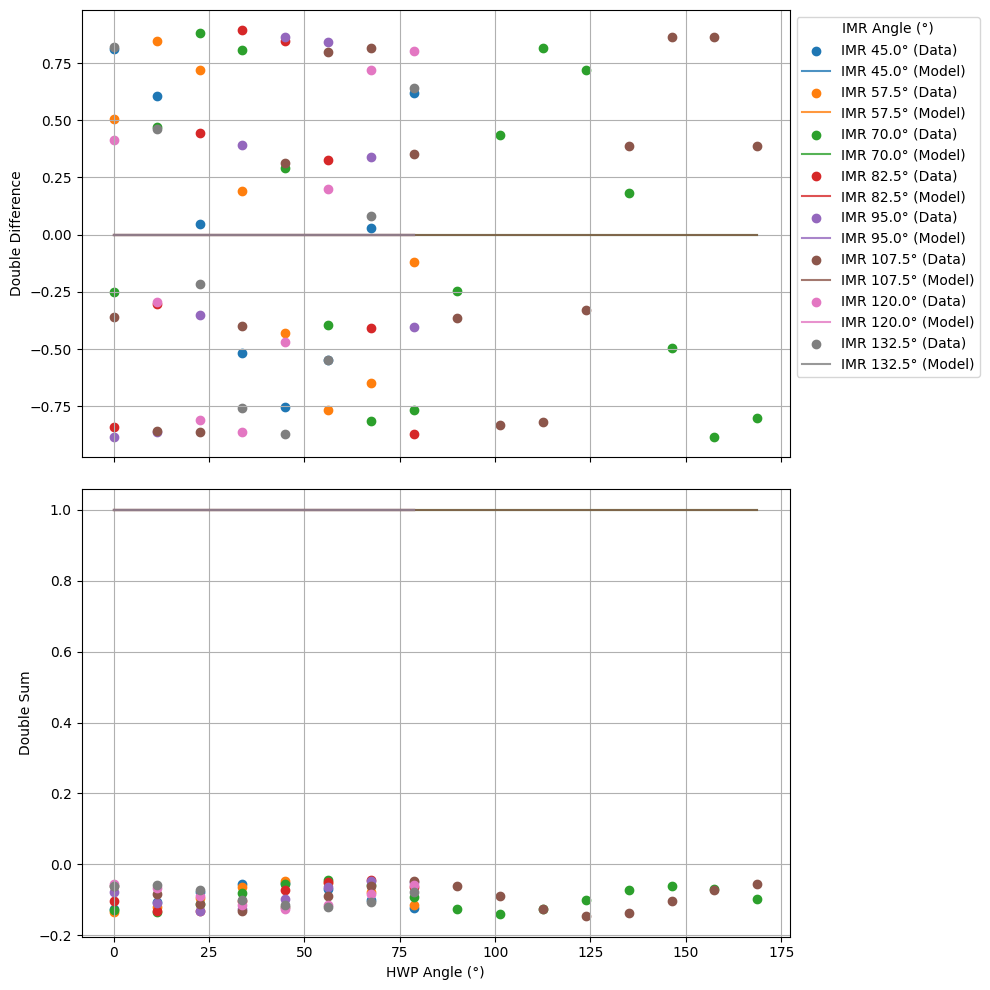

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract best-fit parameters from optimization result
best_dichroic_phi, best_dichroic_theta = result.x  # Best-fit dichroic values

# Extract and sort unique HWP angles (RET-POS1) and IMR angles (D_IMRANG)
hwp_angles_unique = np.sort(data["RET-POS1"].unique())  # Unique HWP angles
imr_angles_unique = np.sort(data["D_IMRANG"].unique())  # Unique IMR angles

# Create a set of valid (HWP, IMR) pairs that exist in the CSV file
valid_hwp_imr_pairs = set(zip(data["RET-POS1"], data["D_IMRANG"]))

# Extract actual HWP and IMR values for each data point in `double_diffs`
hwp_angles = np.array(hwp_angles)  # Ensure this matches the data order
imr_angles = np.array(imr_angles)  # Ensure this matches the data order

# Print extracted angles and valid pairs for verification
print("Extracted Unique HWP Angles:", hwp_angles_unique)
print("Extracted Unique IMR Angles:", imr_angles_unique)
print("Valid HWP and IMR Pairs: ", valid_hwp_imr_pairs)

# Compute model values using best-fit parameters
model_double_diffs = []
model_double_sums = []

# Loop through HWP and IMR angles in actual dataset, skipping invalid ones
for i, HWP_ang in enumerate(hwp_angles_unique):
    for j, IMR_ang in enumerate(imr_angles_unique):
        if (HWP_ang, IMR_ang) not in valid_hwp_imr_pairs:
            # print(f"Skipping HWP = {HWP_ang}, IMR = {IMR_ang} (Not in dataset)")
            continue  # Skip this iteration

        # print(f"Processing HWP = {HWP_ang}, IMR = {IMR_ang}")

        updated_system_dict = {
            "components": {
                "lp": {"type": "LinearPolarizer", "properties": {"theta": theta_pol}, "tag": "internal"},
                "hwp": {"type": "Retarder", "properties": {"phi": 2 * np.pi * delta_HWP, "delta_theta": offset_HWP, "theta": HWP_ang}, "tag": "internal"},
                "image_rotator": {"type": "Retarder", "properties": {"phi": 2 * np.pi * delta_derot, "delta_theta": offset_derot, "theta": IMR_ang}, "tag": "internal"},
                "optics": {"type": "DiattenuatorRetarder", "properties": {"phi": 2 * np.pi * rot_opts, "epsilon": epsilon_opts}, "tag": "internal"},
                "flc": {"type": "Retarder", "properties": {"phi": 0}, "tag": "internal"},  # Start with U_FLC = A
                "dichroic": {"type": "Retarder", "properties": {"phi": best_dichroic_phi, "theta": best_dichroic_theta}, "tag": "internal"},
                "wollaston": {"type": "WollastonPrism", "properties": {"beam": "o", "transmission_ratio": em_gain}, "tag": "internal"},
            },
            "order": ["lp", "hwp", "image_rotator", "optics", "flc", "dichroic", "wollaston"]
        }

        # Generate Mueller matrices for different flux cases
        updated_system_dict["components"]["wollaston"]["properties"]["beam"] = "o"
        system_mm_FL1 = generate_system_mueller_matrix(updated_system_dict)

        updated_system_dict["components"]["wollaston"]["properties"]["beam"] = "e"
        system_mm_FR1 = generate_system_mueller_matrix(updated_system_dict)

        updated_system_dict["components"]["flc"]["properties"]["phi"] = np.pi / 4  # FLC state B
        updated_system_dict["components"]["wollaston"]["properties"]["beam"] = "o"
        system_mm_FL2 = generate_system_mueller_matrix(updated_system_dict)

        updated_system_dict["components"]["wollaston"]["properties"]["beam"] = "e"
        system_mm_FR2 = generate_system_mueller_matrix(updated_system_dict)

        print(system_mm_FR2.evaluate())

        # Generate simulated Stokes measurements for each configuration
        S_in = [1, 1, 0, 0]  # Example: unpolarized + equal linear polarization
        FL1 = generate_measurement(system_mm_FL1, S_in)[0]
        FR1 = generate_measurement(system_mm_FR1, S_in)[0]
        FL2 = generate_measurement(system_mm_FL2, S_in)[0]
        FR2 = generate_measurement(system_mm_FR2, S_in)[0]

        # Compute forward-modeled double difference and sum
        model_double_diff = ((FL1 - FR1) - (FL2 - FR2)) / ((FL1 + FR1) + (FL2 + FR2))
        model_double_sum = ((FL1 - FR1) + (FL2 - FR2)) / ((FL1 + FR1) + (FL2 + FR2))

        # Store computed model values
        model_double_diffs.append(model_double_diff)
        model_double_sums.append(model_double_sum)

# Convert to numpy arrays for plotting
model_double_diffs = np.array(model_double_diffs)
model_double_sums = np.array(model_double_sums)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

print("Data Double Diffs Shape: " + str(np.shape(double_diffs)))
print("Model Double Diffs Shape: " + str(np.shape(model_double_diffs)))

# Plot Double Difference with forward model overlay
for imr_angle in np.unique(imr_angles):
    mask = (np.array(imr_angles) == imr_angle)  # Apply mask correctly

    # Ensure mask and data are same length before applying
    # if len(mask) != len(double_diffs):
    #     # print(f"Skipping IMR {imr_angle} due to mismatched sizes")
    #     continue

    ax[0].scatter(np.array(hwp_angles)[mask], double_diffs[mask], label=f"IMR {imr_angle}° (Data)", marker='o')
    ax[0].plot(np.array(hwp_angles)[mask], model_double_diffs[mask], linestyle='-', alpha=0.8, label=f"IMR {imr_angle}° (Model)")

ax[0].set_ylabel("Double Difference")
ax[0].legend(title="IMR Angle (°)", loc="upper left", bbox_to_anchor=(1, 1))
ax[0].grid()

# Plot Double Sum with forward model overlay
for imr_angle in np.unique(imr_angles):
    mask = (np.array(imr_angles) == imr_angle)
    print("Mask Shape: " + str(np.shape(mask)))

    if len(mask) != len(double_sums):
        print(f"Skipping IMR {imr_angle} due to mismatched sizes")
        continue

    ax[1].scatter(np.array(hwp_angles)[mask], double_sums[mask], label=f"IMR {imr_angle}° (Data)", marker='o')
    ax[1].plot(np.array(hwp_angles)[mask], model_double_sums[mask], linestyle='-', alpha=0.8, label=f"IMR {imr_angle}° (Model)")

ax[1].set_xlabel("HWP Angle (°)")
ax[1].set_ylabel("Double Sum")
ax[1].grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
